Back to the main [Index](index.ipynb)

# Tasks, Workflows and Flow

Before starting, it's worth clarifying some of the basic concepts used in AbiPy 
to automate ab-initio calculations. 
In particular, in this paragraph, we will focus on the following three objects: 

   * `Task`
   * `Work`
   * `Flow`
   
The `Task` represent the most elementary step of the automatic workflow. 
Roughly speaking, it corresponds to the execution of a single Abinit input file (without multiple datasets).

From the point of view of AbiPy, a calculation consists of a set of `Tasks` that are connected together 
by some sort of dependency. 
Each task has a list of files that are needed to start the calculation, 
and a list of files that are produced at the end of the run.
Some of the input files needed by a `Task` must be provided by the user in the form of Abinit input variables 
(e.g. the crystalline structure), other inputs may be produced by other tasks.

When a `Task` B requires the output file `DEN` of another task A, 
we say that B depends on A through F, and we express this dependency using the python dictionary:

```python
B_deps = {A: "DEN"}
```

To clarify this point, let's take a standard $KS$ band structure calculation as an example.
In this case, we have an initial `ScfTask` that solves the KS equations self-consistently to produce a density file. 
The density is then used by a second `NscfTask` to compute a band structure on an arbitrary 
set of $k$-points.
The `NscfTask` has thus a dependency on the first `ScfTask` in the sense that it cannot be executed until the `ScfTask` is completed, and the `DEN` file produced by the `ScfTask` is needed as input.

The `Work` can be seen as a list of `Tasks`, while the `Flow` is a list of `Work` objects.
End-users will mainly interact with the `Flow` since this object provides an easy-to-use
interface for performing common operations (launching jobs, checking the status of the `Tasks` etc). 

AbiPy provides several factory functions for typical first-principles calculations.
This means that you do not need to understand all the technical details of  the python implementation.
In many cases, indeed, we already provide some kind of `Work` or `Flow` that automates 
your calculation, and you only need to provide the correct list of input files 
that obviously must be consistent with the Flow/Work that is being created.
(you shall not pass a list of inputs for performing a band structure calculation to a flow 
that is expected to compute phonons with DFPT!)

All the `Works` and the `Tasks` of a flow are created and executed inside the working directory (`workdir`) 
that is usually specified by the user during the creation of the `Flow` object.
AbiPy created the workdir of the different Works/Tasks when the `Flow` is executed
for the first time.

Each `Task` has an associated set of input variables that will be used to generate the 
Abinit input file and run the calculation. 
This input **must** be provided by the user during the creation of the `Task`.
Fortunately, AbiPy provides an object named `AbinitInput` that facilitates the creation 
of such input. 
Once you have an `AbinitInput`, you can create the corresponding `Task` with the (pseudo) code:

```python
new_task = Task(abinit_input_object)
```

The `Task` provides several methods for monitoring the status of the calculation and 
for post-processing the results.

In the next paragraph, we discuss how to construct a `Flow` for band-structure calculations
with a high-level interface that only requires the specifications on the input files.
This example allows us to discuss the most important methods of the `Flow`.

## Building a Flow  for band structure calculations

Let's start by creating a function that produces two input files. 
The first input is a standard self-consistent ground-state calculation.
The second dataset uses the density produced in the first run to perform 
a non self-consistent band structure calculation.

In [1]:
from __future__ import division, print_function, unicode_literals

%matplotlib notebook

import warnings
warnings.filterwarnings("ignore") # to get rid of deprecation warnings

from abipy import abilab
import abipy.flowtk as flowtk
import abipy.data as abidata

def make_scf_nscf_inputs():
    """Build ands return the input files for the GS-SCF and the GS-NSCF tasks."""
    multi = abilab.MultiDataset(structure=abidata.cif_file("si.cif"),
                              pseudos=abidata.pseudos("14si.pspnc"), ndtset=2)

    # Set global variables (dataset1 and dataset2)
    multi.set_vars(ecut=6, nband=8)

    # Dataset 1 (GS-SCF run)
    multi[0].set_kmesh(ngkpt=[8,8,8], shiftk=[0,0,0])
    multi[0].set_vars(tolvrs=1e-6)

    # Dataset 2 (GS-NSCF run on a k-path)
    kptbounds = [
        [0.5, 0.0, 0.0], # L point
        [0.0, 0.0, 0.0], # Gamma point
        [0.0, 0.5, 0.5], # X point
    ]

    multi[1].set_kpath(ndivsm=6, kptbounds=kptbounds)
    multi[1].set_vars(tolwfr=1e-12)
    
    # Return two input files for the GS and the NSCF run
    scf_input, nscf_input = multi.split_datasets()
    return scf_input, nscf_input

Once we have our two input files, we pass them to the 
factory function `bandstructure_flow` that returns our `Flow`.

In [2]:
scf_input, nscf_input = make_scf_nscf_inputs()

workdir = "/tmp/hello_bands"
flow = flowtk.bandstructure_flow(workdir, scf_input, nscf_input)

`bandstructure_flow` took care of creating the correct dependency between the two tasks.
The `NscfTask`, indeed,  depends on the `ScfTask` in w0/t0, whereas the `ScfTask` has no dependency

**Note** that we don't have to use `getden2 = -1` in the second dataset 
since AbiPy knows how to connect the two steps.

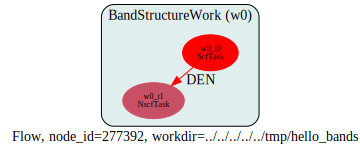

In [3]:
flow.get_graphviz()

To have useful information on the status of the flow, one uses:

In [4]:
flow.show_status()


Work #0: <BandStructureWork, node_id=277393, workdir=../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| Task   | Status      | Queue   | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time   |   Node_ID |
+========+=============+=========+==============+============+==========+=================+========+===========+
| w0_t0  | Initialized | None    | 1|  1|2.0    | NA|NA      | ScfTask  | (0, 0, 0)       | None   |    277394 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+
| w0_t1  | Initialized | None    | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None   |    277395 |
+--------+-------------+---------+--------------+------------+----------+-----------------+--------+-----------+



Meaning of the different columns:
    
   * *Task*: short name of the task (usually t[index_in_work]
   * *Status*: Status of the task
   * *Queue*: Job identifier returned by the resource manager when the task is submitted
   * *(MPI|Omp|Gb)*: Number of MPI procs, OMP threads, and memory per MPI proc
   * *(Warn|Com)*: Number of Error/Warning/Comment messages found in the ABINIT log
   * *Class*: The class of the `Task`
   * *(Sub|Rest|Corr)*: Restart: Number of (submissions/restart.corrections) performed
   * *Node_ID* : identifier of the task, used to select tasks or works in python code or `abirun.py`

## How to build and run the `Flow`

The flow is still in memory and no file has been produced. In order to build the workflow, we use 

In [5]:
#flow.rmtree()
flow.build_and_pickle_dump()

0

This function creates the directories of the `Flow`:

In [6]:
!tree /tmp/hello_bands

/tmp/hello_bands
├── __AbinitFlow__.pickle
├── indata
├── outdata
├── tmpdata
└── w0
    ├── indata
    ├── outdata
    ├── t0
    │   ├── indata
    │   ├── job.sh
    │   ├── outdata
    │   ├── run.abi
    │   ├── run.files
    │   └── tmpdata
    ├── t1
    │   ├── indata
    │   ├── job.sh
    │   ├── outdata
    │   ├── run.abi
    │   ├── run.files
    │   └── tmpdata
    └── tmpdata

15 directories, 7 files


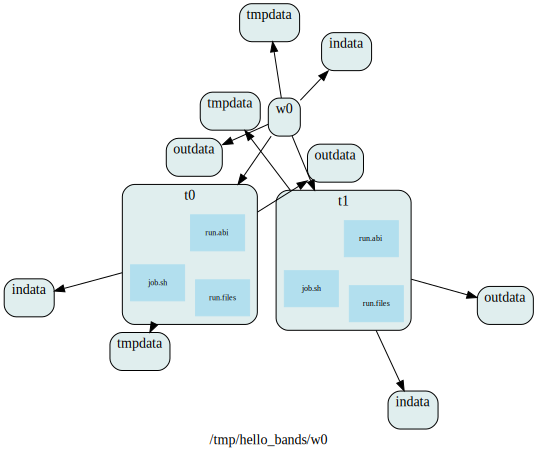

In [7]:
flow[0].get_graphviz_dirtree()

`w0` is the directory containing the input files of the first workflow (well, we have only one workflow in our example).
`t0` and `t1` contain the input files need to run the SCF and the NSC run, respectively.

You might have noticed that each `Task` directory present the same structure:
    
   * *run.abi*: Input file
   * *run.files*: Files file
   * *job.sh*: Submission script
   * *outdata*: Directory containing output data files
   * *indata*: Directory containing input data files 
   * *tmpdata*: Directory with temporary files
   
<div class="alert alert-danger" role="alert">
`__AbinitFlow__.pickle` is the pickle database used to store the `Flow` we have just created. **Don't touch it!** 
</div>

In [8]:
 flow[0][0].input

<AbinitInput at 4615920944>

In [9]:
flow[0][0].input.structure

Structure Summary
Lattice
    abc : 3.8669746200000001 3.8669746200000001 3.8669746200000001
 angles : 59.999999999999993 59.999999999999993 59.999999999999993
 volume : 40.888291793468909
      A : 3.3488982567096763 0.0 1.9334873100000005
      B : 1.1162994189032256 3.1573715557642927 1.9334873100000005
      C : 0.0 0.0 3.8669746200000001
PeriodicSite: Si (0.0000, 0.0000, 0.0000) [0.0000, 0.0000, 0.0000]
PeriodicSite: Si (1.1163, 0.7893, 1.9335) [0.2500, 0.2500, 0.2500]

In [10]:
for p in flow[0][0].input.pseudos: 
    print(p)

<NcAbinitPseudo: 14si.pspnc>
  summary: Troullier-Martins psp for element  Si        Thu Oct 27 17:31:21 EDT 1994
  number of valence electrons: 4.0
  maximum angular momentum: d
  angular momentum for local part: d
  XC correlation: LDA_XC_TETER93
  supports spin-orbit: False
  radius for non-linear core correction: 1.80626423934776
  hint for low accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for normal accuracy: ecut: 0.0, pawecutdg: 0.0
  hint for high accuracy: ecut: 0.0, pawecutdg: 0.0


## Executing a `Flow`

The `Flow` can be executed with two different approaches: a programmatic interface based 
on `make_scheduler` and the `abirun.py` script. 
In this section, we discuss the first approach because it plays well with the jupyter notebook
although `abirun.py` is the recommended method when running non-trivial calculations. 

In [11]:
flow.make_scheduler().start()

[Sun Feb 11 16:46:36 2018] Number of launches: 1

Work #0: <BandStructureWork, node_id=277393, workdir=../../../../../tmp/hello_bands/w0>, Finalized=False
+--------+-------------+-------------+--------------+------------+----------+-----------------+----------+-----------+
| Task   | Status      | Queue       | MPI|Omp|Gb   | Warn|Com   | Class    | Sub|Rest|Corr   | Time     |   Node_ID |
+========+=============+=============+==============+============+==========+=================+==========+===========+
| w0_t0  | Submitted   | 52956@local | 2|  1|2.0    | 0|  0      | ScfTask  | (1, 0, 0)       | 0:00:00Q |    277394 |
+--------+-------------+-------------+--------------+------------+----------+-----------------+----------+-----------+
| w0_t1  | Initialized | None        | 1|  1|2.0    | NA|NA      | NscfTask | (0, 0, 0)       | None     |    277395 |
+--------+-------------+-------------+--------------+------------+----------+-----------------+----------+-----------+

parent <Scf

0

In the first iteration, only the `ScfTask` is executed because the second task depends on it. 
At this point the scheduler will regularly wakes up, inspect the `Tasks` in the flow and 
submit those whose dependency is fulfilled.

In [12]:
flow.show_history()


============================ <BandStructureWork, node_id=277393, workdir=../../../../../tmp/hello_bands/w0> ============================
[Sun Feb 11 16:46:45 2018] Finalized set to True
[Sun Feb 11 16:46:45 2018] Work <BandStructureWork, node_id=277393, workdir=../../../../../tmp/hello_bands/w0> is finalized and broadcasts signal S_OK

=============================== <ScfTask, node_id=277394, workdir=../../../../../tmp/hello_bands/w0/t0> ===============================
[Sun Feb 11 16:46:35 2018] Status changed to Ready. msg: Status set to Ready
[Sun Feb 11 16:46:35 2018] Setting input variables: {'autoparal': 1, 'max_ncpus': 2}
[Sun Feb 11 16:46:35 2018] Old values: {'autoparal': None, 'max_ncpus': None}
[Sun Feb 11 16:46:36 2018] Status changed to Initialized. msg: finished autoparallel run
[Sun Feb 11 16:46:36 2018] Submitted with MPI=2, Omp=1, Memproc=2.0 [Gb] Submitted to queue 
[Sun Feb 11 16:46:40 2018] Task completed status set to ok based on abiout
[Sun Feb 11 16:46:40 2018] F

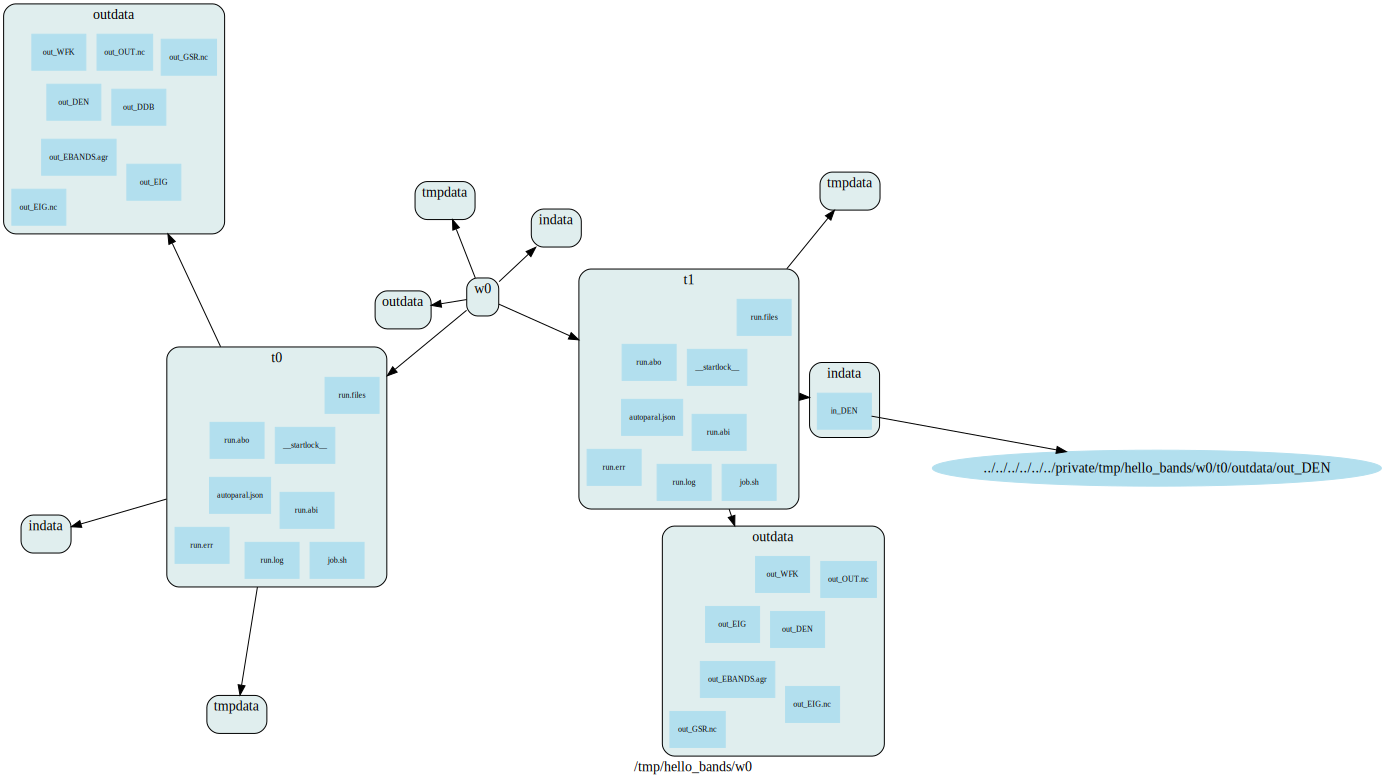

In [13]:
flow[0].get_graphviz_dirtree()

In [14]:
flow.listext("GSR.nc")

Found 2 files with extension `GSR.nc` produced by the flow
File                                                       Size [Mb]    Node_ID  Node Class
-------------------------------------------------------  -----------  ---------  ------------
../../../../../tmp/hello_bands/w0/t0/outdata/out_GSR.nc         0.01     277394  ScfTask
../../../../../tmp/hello_bands/w0/t1/outdata/out_GSR.nc         0.01     277395  NscfTask


<IPython.core.display.Javascript object>


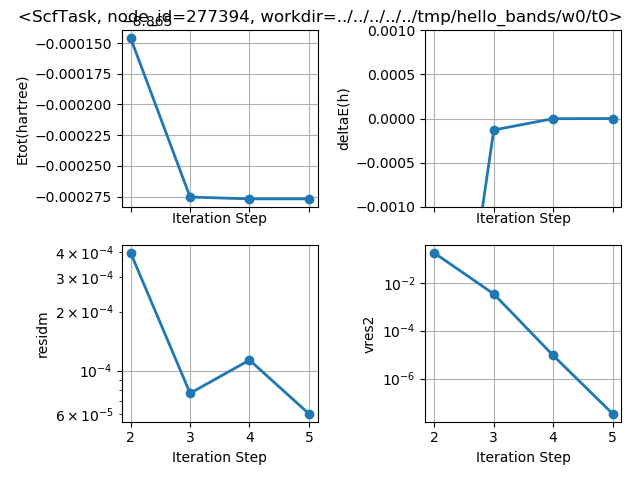

Task <NscfTask, node_id=277395, workdir=../../../../../tmp/hello_bands/w0/t1> does not provide an inspect method


In [15]:
flow.inspect(tight_layout=True);

In [16]:
with flow[0][0].open_gsr() as gsr:
    print(gsr)
    ebands_kmesh = gsr.ebands

================================= File Info =================================
Name: out_GSR.nc
Directory: /tmp/hello_bands/w0/t0/outdata
Size: 15.15 kb
Access Time: Sun Feb 11 16:47:00 2018
Modification Time: Sun Feb 11 16:46:37 2018
Change Time: Sun Feb 11 16:46:37 2018

================================= Structure =================================
Full Formula (Si2)
Reduced Formula: Si
abc   :   3.866975   3.866975   3.866975
angles:  60.000000  60.000000  60.000000
Sites (2)
  #  SP       a     b     c  cartesian_forces
---  ----  ----  ----  ----  -----------------------
  0  Si    0     0     0     [ 0.  0.  0.] eV ang^-1
  1  Si    0.25  0.25  0.25  [ 0.  0.  0.] eV ang^-1

Abinit Spacegroup: spgid: 227, num_spatial_symmetries: 48, has_timerev: True, symmorphic: True

Stress tensor (Cartesian coordinates in Ha/Bohr**3):
[[  1.77138824e-04   2.67308023e-15   3.78028771e-15]
 [  2.67308023e-15   1.77138824e-04   2.67307335e-15]
 [  3.78028771e-15   2.67307335e-15   1.77138824e-04]]


<IPython.core.display.Javascript object>


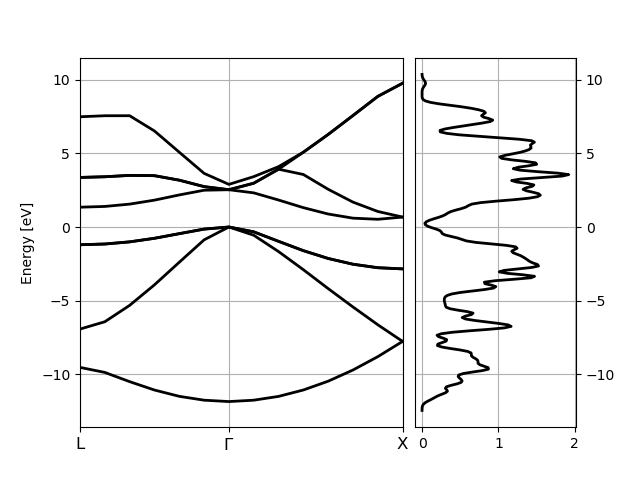

In [17]:
with flow[0][1].open_gsr() as gsr:
    gsr.ebands.plot_with_edos(ebands_kmesh.get_edos());

## More on `Works` and `Tasks` 

Both `Flow` and `Work` are iterable. 
Iterating on a `Flow` gives `Work` objects, whereas
iterating over a `Work` will give the `Tasks` inside that particular `Work`.

```python
for work in flow:
    for task in work:
        print(task)
```

One can also "slice" `Flows` and `Works` i.e. one can select a slice or works or tasks
with the syntax: flow[start:stop] or work[start:stop]
This means that the previous loop is equivalent to the much more verbose version: 

```python
for i in range(len(flow)):
    work = flow[i]
    for t in range(len(work):
        print(work[t])
```

In [18]:
#from abipy.abio import factories as abifact
#from abipy import flowtk
#import abipy.data as abidata
#structure = abilab.Structure.from_file(abidata.cif_file("si.cif"))
#pseudos = abidata.pseudos("14si.pspnc")
#gsinp = abifact.gs_input(structure, pseudos)

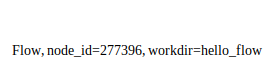

In [19]:
hello_flow = flowtk.Flow(workdir="hello_flow")
hello_flow.get_graphviz()

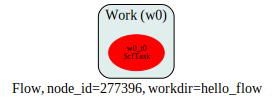

In [20]:
hello_flow.register_scf_task(scf_input, append=True)
hello_flow.get_graphviz()

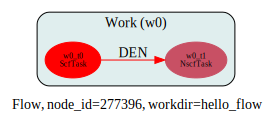

In [21]:
# Note the error here
hello_flow.register_nscf_task(scf_input, deps={hello_flow[0][0]: "DEN"}, append=True)
hello_flow.get_graphviz(engine="dot")

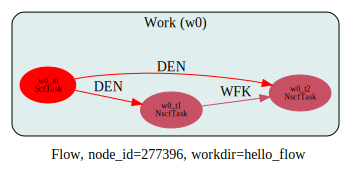

In [22]:
hello_flow.register_nscf_task(scf_input, deps={hello_flow[0][0]: "DEN", hello_flow[0][1]: "WFK"}, append=True)
hello_flow.get_graphviz(engine="dot")

In [23]:
#hello_flow[0].get_graphviz()

In [24]:
#hello_flow[0][1].get_graphviz()

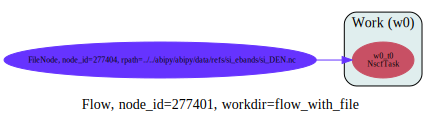

In [25]:
# Create a Work, all tasks in work will start from the DEN file.
# Note that the file must exist when the work is created
# Use the standard approach based on tasks and works if
# there's a node who needs a file produced in the future.
# Specify dep with absolute path
flow_with_file = flowtk.Flow(workdir="flow_with_file")

den_filepath = abidata.ref_file("si_DEN.nc")
flow_with_file.register_nscf_task(nscf_input, deps={den_filepath: "DEN"})

flow_with_file.get_graphviz(engine="dot")

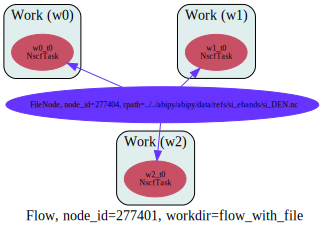

In [26]:
for nband in [10, 20]:
    flow_with_file.register_nscf_task(nscf_input.new_with_vars(nband=nband), 
                                      deps={den_filepath: "DEN"}, append=False)
flow_with_file.get_graphviz()

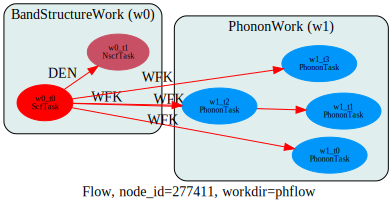

In [27]:
# Why works?
phflow = flowtk.Flow(workdir="phflow")
bands_work = flowtk.BandStructureWork(scf_input, nscf_input, dos_inputs=None)
phflow.register_work(bands_work)    
    
scf_task = bands_work[0]
ph_work = flowtk.PhononWork.from_scf_task(scf_task, [2, 2, 2], is_ngqpt=True, tolerance=None)
phflow.register_work(ph_work) 

phflow.get_graphviz()

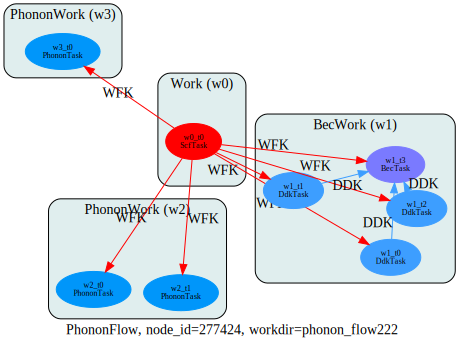

In [28]:
auto_phflow = flowtk.PhononFlow.from_scf_input("phonon_flow222", scf_input, [2, 2, 2], with_becs=True)
auto_phflow.get_graphviz()

## TaskManager

In the previous sections, we have discussed how to define, build and run a `Flow`, but there is a very important point that we haven't discussed yet.
It should be stressed, indeed, that AbiPy is only driving and monitoring the `Flow` while the actual calculation is delegated to Abinit (a Fortran program that is usually executed in parallel on multiple CPUs that communicate via the network by means of the MPI protocol).
Besides CPUs and memory must be reserved in advance by sending a request to the resource manager installed on the clusters (SLURM, PBS, etc)

AbiPy gets all the information needed to submit the different `Tasks` 
from a configuration file, `manager.yml`, that is usually located in the directory `~/.abinit/abipy/`.

<div class="alert alert-success">
For a brief introduction to the YAML format, please consult http://en.wikipedia.org/wiki/YAML
</div>

`manager.yml` contains a list of `QueueAdapters` objects. 
Each `QueueAdapter` is responsible for all interactions with a 
specific queue management system (slurm, PBS, bash, etc).
This includes handling all details of queue script format as well as queue submission and management.
The configuration file I use on my laptop is:

qadapters:
    # List of qadapters objects 
    - priority: 1
      queue:
        qtype: shell
        qname: gmac
      job:
        mpi_runner: mpirun
        pre_run: "source ~/env.sh"
      limits:
        timelimit: 1:00:00
        max_cores: 2
      hardware:
         num_nodes: 1
         sockets_per_node: 1
         cores_per_socket: 2
         mem_per_node: 4 Gb

For the sake of brevity, we just try to give you a general overview of the meaning 
of the different sections without entering into detail.
 
* queue: dictionary with the name of the queue and optional parameters 
     used to build/customize the header of the submission script.
* job: dictionary with the options used to prepare the enviroment before submitting the job
* limits: dictionary with the constraints that must be fulfilled in order to run with this queueadapter.
* hardware: dictionary with information on the hardware available on this particular queue.

In this (simple) case, we have one `QueueAdapter` named `gmac` that will submit `Tasks`
in a shell subprocess (`qtype: shell`) via mpirun. 
`env.sh` is the bash script I use to set the value of the environment variables (e.g. `PATH` and `LD_LIBRARY_PATH`) before running ABINIT.

Note that my laptopt has 1 socket with 2 CPUs and 4 Gb of memory in total, hence I don't want
to run ABINIT tasks with more than 2 CPUs. This is the reason why `max_cores` is set to 2.
`Timelimit` is not used when you are using `qname=shell`, but it is very important when you are submitting jobs on a cluster because this value is used to generate the submission script.

At this point, you may wonder why we need to specify all these parameters in the configuration file.
The reason is that, before submitting a job to a resource manager, `AbiPy` will use the autoparal feature of ABINIT to get all the possible parallel configurations with `ncpus <= max_cores`. 
On the basis of these results, `AbiPy` selects the "optimal" one, and changes the ABINIT input file and the submission script sccordingly .
(this is a very useful feature, especially for calculations done with `paral_kgb=1` that require the specification of `npkpt`, `npfft`, `npband`, etc).
If more than one `QueueAdapter` is specified, `AbiPy` will first compute all the possible configuration and then select the "optimal" `QueueAdapter` according to some kind of policy.

The complete list of options supported by the `TaskManager` with slurm can be 
retrieved with the command:

In [31]:
!abidoc.py manager slurm


# TaskManager configuration file (YAML Format)

policy:
    # Dictionary with options used to control the execution of the tasks.

qadapters:
    # List of qadapters objects (mandatory)
    -  # qadapter_1
    -  # qadapter_2

db_connector:
    # Connection to MongoDB database (optional)

batch_adapter:
    # Adapter used to submit flows with batch script. (optional)

##########################################
# Individual entries are documented below:
##########################################

policy: 
    autoparal:                # (integer). 0 to disable the autoparal feature (DEFAULT: 1 i.e. autoparal is on)
    condition:                # condition used to filter the autoparal configurations (Mongodb-like syntax).
                              # DEFAULT: empty i.e. ignored.
    vars_condition:           # Condition used to filter the list of ABINIT variables reported by autoparal
                              # (Mongodb-like syntax). DEFAULT: empty i.e. ignored.
    frozen_time

<div class="alert alert-success">
`Abipy` will read the `manager.yml` file automatically when a new `Flow` is created. 
By default, python looks for a `manager.yml` file in the current working directory and 
then in `~/.abinit/abipy`. 
</div>

## Scheduler

The other configuration file is named `scheduler.yml` and defines the parameters 
for the scheduler that will run/submit our jobs

In [32]:
!cat ~/.abinit/abipy/scheduler.yml

max_njobs_inqueue: 2
max_ncores_used: 4

# number of weeks to wait.
#weeks: 0

# number of days to wait.
#days: 0

# number of hours to wait.
#hours: 0

# number of minutes to wait.
#minutes: 0

# number of seconds to wait.
seconds: 5

# when to first execute the job and start the counter (default is after the given interval).
#start_date:

# Send mail to the specified address (accepts string or list of strings).
# PRO TIP: the scheduler WILL try to send and email after a default time of 4 days. If you 
#          comment out the mailto address, this will cause the scheduler to terminate, with
#          potentially nefarious effects on your running jobs. If you do not wish to receive
#          emails, a work around is to set the variable `remindme_s` below to something very
#          large (say, 100 days).
#mailto: nobody@nowhere.com

# verbosity level (int, default 0)
#verbose: 0

# The scheduler will shutdown when the number of python exceptions is > max_num_pyexcs
#max_num_pyexcs

<div class="alert alert-success">
Also in this case, AbiPy will read the `scheduler.yml` file automatically when `make_scheduler` 
is called without arguments. 
A file `manager.yml` located in the current working directory takes precedence over `~/.abinit/abipy/manager.yml`. 
</div>

<div class="alert alert-error">
Remember to set the time interval of the scheduler to a reasonable value.
A small value leads to an increase of the submission rate but it also increases the CPU load 
and the pressure on the hardware and on the resource manager.
A too large time interval can have a detrimental effect on the throughput, especially 
if you are submitting many small jobs.
</div>

The complete list of options supported by scheduler can be retrieved with the command:

In [34]:
!abidoc.py scheduler

Options that can be specified in scheduler.yml:

            weeks: number of weeks to wait (DEFAULT: 0).
            days: number of days to wait (DEFAULT: 0).
            hours: number of hours to wait (DEFAULT: 0).
            minutes: number of minutes to wait (DEFAULT: 0).
            seconds: number of seconds to wait (DEFAULT: 0).
            mailto: The scheduler will send an email to `mailto` every `remindme_s` seconds.
                (DEFAULT: None i.e. not used).
            verbose: (int) verbosity level. (DEFAULT: 0)
            use_dynamic_manager: "yes" if the :class:`TaskManager` must be re-initialized from
                file before launching the jobs. (DEFAULT: "no")
            max_njobs_inqueue: Limit on the number of jobs that can be present in the queue. (DEFAULT: 200)
            remindme_s: The scheduler will send an email to the user specified by `mailto` every `remindme_s` seconds.
                (int, DEFAULT: 1 day).
            max_num_pyexcs: The schedu

## Abirun.py

Executing `flow.make_scheduler().start()` inside an ipython notebook is handy if you are dealing with small calculations that require few seconds or minutes. 
This approach, however, is unpractical when you have large flows or big calculations requiring hours or days, even on massively parallel machines.
In this case, indeed, one would like to run the scheduler in a separate process in the backgroud so that the scheduler is not killed when the ipython notebook server is closed.

To start the scheduler in a separate process, use the `abirun.py` script.
The syntax is 

```bash
$> abirun.py flow_workdir command
```

where `flow_workdir` is the directory containing the `Flow` (the directory with the pickle file) and `command` selects the operation to be performed.

Typical examples:

```bash
$> abirun.py /tmp/hello_bands status
```
checks the status of the `Flow` and print the results to screen.

```bash
$> nohup abirun.py /tmp/hello_bands scheduler > sched.log &
```

Starts the scheduler in the background redirecting the standard output to file `sched.log`

<div class="alert alert-success">
`nohup` is a standard Unix tool. The command make the scheduler immune 
to hangups so that you can close the shell session without killing the scheduler.
</div>

`--help` gives the complete list of commands and options available: 

In [33]:
!abirun.py --help

usage: abirun.py [-h] [-V]
                 [flowdir]
                 {single,rapid,scheduler,batch,status,set_status,cancel,restart,reset,move,open,abiopen,abibuild,doc_scheduler,new_manager,tail,deps,robot,cycles,dims,inspect,inputs,abivars,structures,ebands,hist,doc_manager,events,corrections,history,handlers,notebook,ipython,tar,tricky,debug,debug_reset,clone_task,group,diff,networkx,graphviz,listext}
                 ...

positional arguments:
  flowdir               File or directory containing the ABINIT
                        flow/work/task. If not given, the flow in the current
                        workdir is selected.

optional arguments:
  -h, --help            show this help message and exit
  -V, --version         show program's version number and exit

subcommands:
  Valid subcommands

  {single,rapid,scheduler,batch,status,set_status,cancel,restart,reset,move,open,abiopen,abibuild,doc_scheduler,new_manager,tail,deps,robot,cycles,dims,inspect,inputs,abivars,structure

Back to the main [Index](index.ipynb)